# Specific Test 3: Image Super-resolution

### Name: Shashwat Srivastava
### Project: Superresolution for Strong Gravitational Lensing (DeepLense)
### Evaluation Test Notebook

### Importing necessary libraries

In [115]:
# File navigation
import os
from pathlib import Path

# Neural network
import torch
from torch import nn, Tensor
from torchvision.models import vgg19

# Data pipeline and cleaning
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, Subset
from torchvision.transforms import Compose, Lambda, functional, Pad

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Metrics
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

# Miscellaneous
import numpy as np
import pandas as pd
import copy
from torchsummary import summary
from tqdm import tqdm
from typing import List, Tuple
import warnings

### Basic settings

In [225]:
plt.style.use('dark_background')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Device being used: {device}')

Device being used: mps


### Utility functions

In [108]:
# Image transform functions
transforms = Compose([Lambda(lambda x: functional.convert_image_dtype(torch.tensor(x)))])
transforms_lr = Compose([Lambda(lambda x: functional.convert_image_dtype(torch.tensor(x))),
                         Pad((5,5,6,6))])
transforms_hr = Compose([Lambda(lambda x: functional.convert_image_dtype(torch.tensor(x))),
                         Pad(11)])

# MSE loss
def mse(x,y):
    return torch.nn.MSELoss()(x,y)

# Structural similarity
def ssim(x,y):
    m = list()
    for i,j in zip(x,y):
        m.append(structural_similarity(i.numpy(), j.numpy(), channel_axis=0, data_range=1))
    return np.mean(m)

# Peak signal to noise ratio
def psnr(x,y):
    m = list()
    for i,j in zip(x,y):
        np.seterr(divide = 'raise')
        try:
            val = peak_signal_noise_ratio(255*i.numpy().astype(np.uint8)[0], 255*j.numpy().astype(np.uint8)[0], data_range=255)
        except:
            continue
        m.append(val)
    return np.mean(m)

# Custom vgg19 loss for SRGAN training
def vgg_loss(x,y):
    net=vgg19(pretrained=True).features[:-1]
    for m in net.parameters():
        m.requires_grad=False
    mse = nn.MSELoss()
    x_, y_ = nn.functional.conv2d(x,torch.ones((3,1,1,1)).to(x.device)), nn.functional.conv2d(y,torch.ones((3,1,1,1)).to(y.device))
    loss = mse(net(x_),net(y_))
    return loss

## Task 3A

### Data Visualization

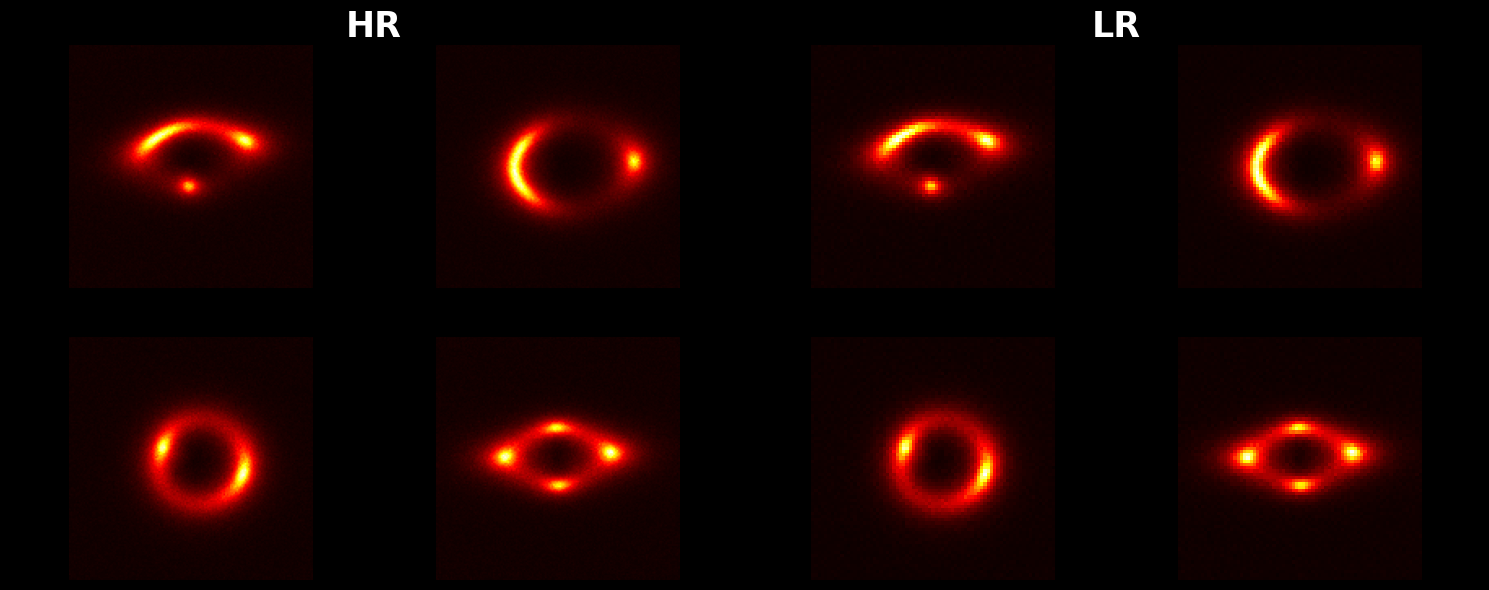

In [98]:
# Loading data
path=Path('datasets/Test 3A')
dirs = [i for i in path.iterdir() if i.name in ['LR', 'HR']]
fig = plt.figure(figsize = (15,6))
iax = gridspec.GridSpec(1, 2, figure=fig)

grid = 2 # no. of images in each row and column of the grid (can be changed to anything)

# Plotting grid
for ax, cls in zip(iax, dirs):
    out_ax = fig.add_subplot(ax)
    out_ax.set_title(f'{cls.name}', fontsize=25, fontweight='bold')
    out_ax.axis('off')
    jax = gridspec.GridSpecFromSubplotSpec(grid, grid, subplot_spec=ax)
    for i, img in zip(range(grid**2), cls.glob('*.npy')):
        in_ax = fig.add_subplot(jax[i//grid, i%grid])
        in_ax.imshow(np.load(img)[0], cmap='hot')
        in_ax.axis('off')
plt.tight_layout()

### Data Pipeline

In [6]:
class data (Dataset):
    
    def __init__(self, transform: Compose, split: str) -> None:
        
        self.path: Path = Path.cwd() / 'datasets' / 'Test 3A' # Path object

        # Creating LR-HR path pair
        self.LR_HR_pair: List[tuple] = [(file1,file2) for file1,file2 in zip((self.path/'LR').iterdir(),(self.path/'HR').iterdir())]

        # train/test/val splitting based on choice
        self.train, self.val, self.test = random_split(self.LR_HR_pair,[0.85,0.05,0.1])
        self.loader: Subset = self.train if split == 'train' else (self.test if split == 'test' else self.val)
        
        self.transform = transform # image transforms

    def __len__(self) -> int:
        return len(self.loader)
        
    def __getitem__(self, i: int) -> Tuple[Tensor, Tensor]:
        return self.transform(np.load(self.loader[i][0])), self.transform(np.load(self.loader[i][1]))

### Data Loaders

In [11]:
train_loader = DataLoader(data(transforms, 'train'), batch_size=128, shuffle=True)
val_loader = DataLoader(data(transforms, 'val'), batch_size=128, shuffle=True)
test_loader = DataLoader(data(transforms, 'test'), batch_size=128, shuffle=True)

## Models

Two different models have been used for this task independently:

1) Super resolution convolutional neural networks (SRCNN)
2) Super resolution generative adversarial networks (SRGAN)

The results of these two models have been shown in the upcoming cells

### SRCNN Model

#### Model architecture

In [58]:
class SRCNN(nn.Module):
    
    blocke = lambda self,i,o,k,s,p: nn.Sequential(nn.Conv2d(i,o,k,s,p),nn.ReLU())
    blockd = lambda self,i,o,k,s,p: nn.Sequential(nn.ConvTranspose2d(i,o,k,s,p),nn.ReLU())
    
    def __init__(self) -> None:
        
        super(SRCNN, self).__init__()

        # Encoder block
        self.e=nn.Sequential(self.blocke(1,32,3,2,1),
                             self.blocke(32,64,3,2,1),
                             self.blocke(64,128,3,2,1),
                             self.blocke(128,256,3,2,1))

        # Decoder block
        self.d=nn.Sequential(self.blockd(256,128,4,2,1),
                             self.blockd(128,64,3,2,1),
                             self.blockd(64,32,4,2,1),
                             self.blockd(32,16,3,2,1),
                             nn.ConvTranspose2d(16,1,4,2,1),
                             nn.ReLU())
        
    def forward(self, x: Tensor) -> Tensor:
        return self.d(self.e(x))
        
summary(SRCNN(), (1,75,75), device='cpu') # Architecture summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 38, 38]             320
              ReLU-2           [-1, 32, 38, 38]               0
            Conv2d-3           [-1, 64, 19, 19]          18,496
              ReLU-4           [-1, 64, 19, 19]               0
            Conv2d-5          [-1, 128, 10, 10]          73,856
              ReLU-6          [-1, 128, 10, 10]               0
            Conv2d-7            [-1, 256, 5, 5]         295,168
              ReLU-8            [-1, 256, 5, 5]               0
   ConvTranspose2d-9          [-1, 128, 10, 10]         524,416
             ReLU-10          [-1, 128, 10, 10]               0
  ConvTranspose2d-11           [-1, 64, 19, 19]          73,792
             ReLU-12           [-1, 64, 19, 19]               0
  ConvTranspose2d-13           [-1, 32, 38, 38]          32,800
             ReLU-14           [-1, 32,

#### Training initialization

In [13]:
model = SRCNN().to(device)                                     # model initialization and sending to device
l = nn.MSELoss()                                               # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
met_train = list()                                          # storing training metrics
met_val = list()                                            # storing validation metrics
model.train()                                               # setting model to training mode

#### Training

In [14]:
for epoch in range(epochs):
    m1,m2,m3 = 0,0,0
    for i, (lr, hr) in enumerate(tqdm(train_loader, desc = f'Epochs: {epoch+1}/{epochs}', ncols = 100)):
        
        optimizer.zero_grad()                   # initializing gradients to zero
        y_pred = model(lr.to(device))           # model prediction
        loss = l(y_pred, hr.to(device))         # MSE loss calculation
        loss.backward()                         # Backpropagation (gradient calculation)
        
        with torch.no_grad():
            optimizer.step()                    # one step towards steepest gradient
            m1 += mse(y_pred.detach(),hr)       # mse accumulation
            m2 += ssim(y_pred.detach(),hr)      # ssim accumulation
            m3 += psnr(y_pred.detach(),hr)      # psnr accumulation
            
    with torch.no_grad():
        met_train.append({'mse':m1/(i+1), 'ssim':m2/(i+1), 'psnr':m3/(i+1)})
        print(f"MSE: {met_train[-1]['mse']} \t  SSIM: {met_train[-1]['ssim']} \t  PSNR: {met_train[-1]['psnr']}\n")

        # Validation
        m1,m2,m3 = 0,0,0
        for i, (lr, hr) in enumerate(tqdm(val_loader, desc = f'Validating: ')):
            pred = model(lr.to(device))
            m1 += mse(pred.detach(), hr)
            m2 += ssim(pred.detach(), hr)
            m3 += psnr(pred.detach(), hr)
        met_val.append({'mse':m1/(i+1), 'ssim':m2/(i+1), 'psnr':m3/(i+1)})
        print(f"MSE: {met_val[-1]['mse']} \t  SSIM: {met_val[-1]['ssim']} \t  PSNR: {met_val[-1]['psnr']}\n")

Epochs: 1/10: 100%|█████████████████████████████████████████████████| 67/67 [00:56<00:00,  1.19it/s]


MSE: 0.00796989630907774 	  SSIM: 0.6018662977574477 	  PSNR: 43.443774426963074



Validating: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


MSE: 0.0030088950879871845 	  SSIM: 0.8095857948064804 	  PSNR: 43.4382958450323



Epochs: 2/10: 100%|█████████████████████████████████████████████████| 67/67 [00:55<00:00,  1.20it/s]


MSE: 0.0014978908002376556 	  SSIM: 0.8741505270573631 	  PSNR: 43.44133368602262



Validating: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


MSE: 0.0005742968060076237 	  SSIM: 0.9274413734674454 	  PSNR: 43.43464650510642



Epochs: 3/10: 100%|█████████████████████████████████████████████████| 67/67 [00:56<00:00,  1.18it/s]


MSE: 0.0003804772568400949 	  SSIM: 0.9405551988687089 	  PSNR: 43.41735145970215



Validating: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


MSE: 0.0003101776819676161 	  SSIM: 0.9477754086256027 	  PSNR: 43.3693638686545



Epochs: 4/10: 100%|█████████████████████████████████████████████████| 67/67 [00:56<00:00,  1.18it/s]


MSE: 0.00025515351444482803 	  SSIM: 0.952065458938257 	  PSNR: 43.40200996275338



Validating: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


MSE: 0.0002389206929365173 	  SSIM: 0.9546791911125183 	  PSNR: 43.42030889730448



Epochs: 5/10: 100%|█████████████████████████████████████████████████| 67/67 [00:56<00:00,  1.19it/s]


MSE: 0.00023882872483227402 	  SSIM: 0.9559388863506602 	  PSNR: 43.29474779189524



Validating: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


MSE: 0.000253796111792326 	  SSIM: 0.9567842185497284 	  PSNR: 43.22102367536334



Epochs: 6/10: 100%|█████████████████████████████████████████████████| 67/67 [00:56<00:00,  1.18it/s]


MSE: 0.00018069491488859057 	  SSIM: 0.9590658358673552 	  PSNR: 43.40074147416694



Validating: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


MSE: 0.0001648461475269869 	  SSIM: 0.9602280855178833 	  PSNR: 43.393351646489805



Epochs: 7/10: 100%|█████████████████████████████████████████████████| 67/67 [00:56<00:00,  1.19it/s]


MSE: 0.00015379764954559505 	  SSIM: 0.961123205832581 	  PSNR: 43.41711914384291



Validating: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


MSE: 0.00015245912072714418 	  SSIM: 0.9616949111223221 	  PSNR: 43.38897628513517



Epochs: 8/10: 100%|█████████████████████████████████████████████████| 67/67 [00:56<00:00,  1.18it/s]


MSE: 0.00014491430192720145 	  SSIM: 0.9623858208086953 	  PSNR: 43.407458592198836



Validating: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


MSE: 0.0001412139245076105 	  SSIM: 0.9628622978925705 	  PSNR: 43.42532041418471



Epochs: 9/10: 100%|█████████████████████████████████████████████████| 67/67 [00:56<00:00,  1.19it/s]


MSE: 0.00013746392505709082 	  SSIM: 0.9632892902217695 	  PSNR: 43.41234184601864



Validating: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


MSE: 0.00013577158097177744 	  SSIM: 0.9634322673082352 	  PSNR: 43.38190521110304



Epochs: 10/10: 100%|████████████████████████████████████████████████| 67/67 [00:56<00:00,  1.19it/s]


MSE: 0.00014465181448031217 	  SSIM: 0.9635661618033452 	  PSNR: 43.35675793352741



Validating: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]

MSE: 0.0001268125488422811 	  SSIM: 0.9644246697425842 	  PSNR: 43.37120671134526



#### Plotting training metrics

Text(0.5, 1.0, 'PSNR')

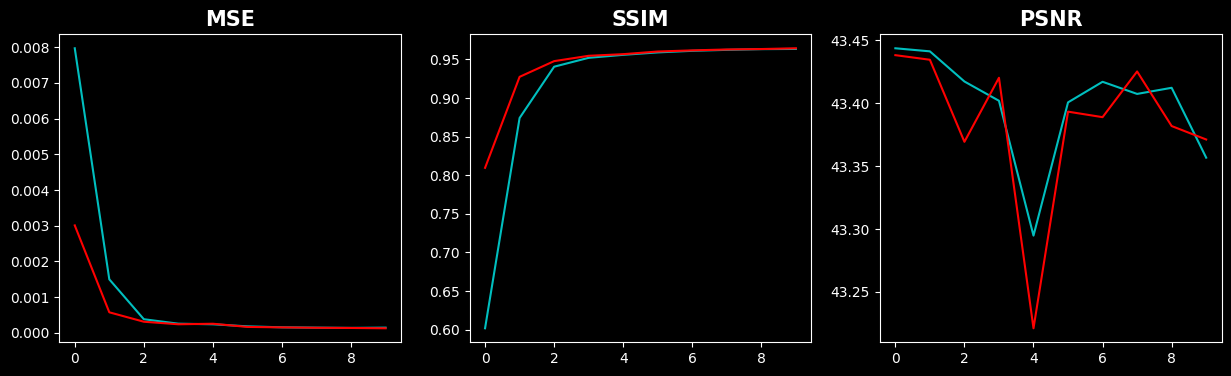

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))
# MSE plot
ax1.plot([i['mse'] for i in met_train],c='c')
ax1.plot([i['mse'] for i in met_val],c='r')
ax1.set_title('MSE', fontsize=15, fontweight='bold')
# SSIM plot
ax2.plot([i['ssim'] for i in met_train],c='c')
ax2.plot([i['ssim'] for i in met_val],c='r')
ax2.set_title('SSIM', fontsize=15, fontweight='bold')
# PSNR plot
ax3.plot([i['psnr'] for i in met_train],c='c')
ax3.plot([i['psnr'] for i in met_val],c='r')
ax3.set_title('PSNR', fontsize=15, fontweight='bold')

#### Saving model parameters and metrics

In [16]:
torch.save({'model':model.state_dict(),
            'met_train':met_train,
            'met_val':met_val},f'chkpt_srcnn.pt')

#### Loading saved model parameters and metrics

In [20]:
model.load_state_dict(torch.load('chkpt_srcnn.pt')['model'])
met_train = torch.load('chkpt_srcnn.pt')['met_train']
met_val = torch.load('chkpt_srcnn.pt')['met_val']

#### Evaluation

In [54]:
model.eval() # setting model to evaluation mode

with torch.no_grad():
    m1,m2,m3 = 0,0,0
    for i, (lr, hr) in enumerate(tqdm(test_loader, desc = f'Evaluating: ')):
        pred = model(lr.to(device))
        m1 += mse(pred.detach(), hr)
        m2 += ssim(pred.detach(), hr)
        m3 += psnr(pred.detach(), hr)
    print(f"\nMSE: {m1/(i+1)} \t  SSIM: {m2/(i+1)} \t  PSNR: {m3/(i+1)}\n")

# Saving metrics
MSE = (m1/(i+1)).item()
SSIM = (m2/(i+1)).item()
PSNR = (m3/(i+1)).item()

Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.57it/s]


MSE: 0.00012534823326859623 	  SSIM: 0.964429959654808 	  PSNR: 43.38424705028039



#### Sample prediction

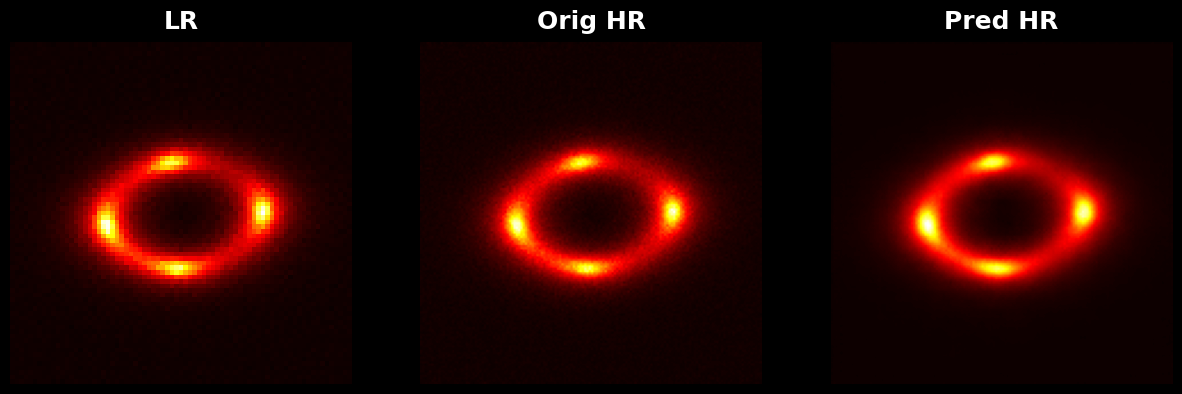

In [50]:
lr, hr = next(iter(test_loader))
pred = model(lr.to(device))
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,6))
ax1.imshow(lr[0][0],cmap='hot')
ax1.set_title('LR',fontsize=18,fontweight='bold',pad=10)
ax1.axis('off')
ax2.imshow(hr[0][0].detach(),cmap='hot')
ax2.set_title('Orig HR',fontsize=18,fontweight='bold',pad=10)
ax2.axis('off')
ax3.imshow(pred.detach()[0][0],cmap='hot')
ax3.set_title('Pred HR',fontsize=18,fontweight='bold',pad=10)
ax3.axis('off')
plt.show()

#### SRCNN evaluation metrics summary

In [55]:
pd.DataFrame({'Metrics':['MSE', 'SSIM', 'PSNR'],
              'Score':[MSE, SSIM, PSNR]})

,Metrics,Score
0,MSE,0.000125
1,SSIM,0.964430
2,PSNR,43.384247


### SRGAN Model

#### Discriminator architecture

In [60]:
class Discriminator(nn.Module):
    conv_block = lambda self,i,o,k,s=1,p=0: nn.Sequential(nn.Conv2d(i,o,k,s,p),
                                                          nn.BatchNorm2d(o),
                                                          nn.LeakyReLU(0.2))
    def __init__(self) -> None:
        super (Discriminator,self).__init__()
        
        self.l = nn.Sequential(nn.Conv2d(1,64,3,1,1),
                            nn.LeakyReLU(0.2),
                            self.conv_block(64,64,3,2,1),
                            self.conv_block(64,128,3,1,1),
                            self.conv_block(128,128,3,2,1),
                            self.conv_block(128,256,3,1,1),
                            self.conv_block(256,256,3,2,1),
                            self.conv_block(256,512,3,1,1),
                            self.conv_block(512,512,3,2,1),
                            nn.Flatten(),
                            nn.Linear(512*10*10,1),
                            nn.Sigmoid())
        
    def forward(self, x: Tensor) -> Tensor:
        return self.l(x)

summary(Discriminator(),(1,150,150),device='cpu') # Architecture summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]             640
         LeakyReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3           [-1, 64, 75, 75]          36,928
       BatchNorm2d-4           [-1, 64, 75, 75]             128
         LeakyReLU-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
       BatchNorm2d-7          [-1, 128, 75, 75]             256
         LeakyReLU-8          [-1, 128, 75, 75]               0
            Conv2d-9          [-1, 128, 38, 38]         147,584
      BatchNorm2d-10          [-1, 128, 38, 38]             256
        LeakyReLU-11          [-1, 128, 38, 38]               0
           Conv2d-12          [-1, 256, 38, 38]         295,168
      BatchNorm2d-13          [-1, 256, 38, 38]             512
        LeakyReLU-14          [-1, 256,

#### Generator architecture

In [77]:
class Generator(nn.Module):
    
    blocke = lambda self,i,o,k,s,p: nn.Sequential(nn.Conv2d(i,o,k,s,p),nn.BatchNorm2d(o),nn.ReLU(o))
    blockd = lambda self,i,o,k,s,p: nn.Sequential(nn.ConvTranspose2d(i,o,k,s,p),nn.BatchNorm2d(o),nn.ReLU(o))
    
    def __init__(self) -> None:
        super(Generator,self).__init__()
        
        self.e = nn.Sequential(self.blocke(1,32,3,2,1),
                              self.blocke(32,64,3,2,1),
                              self.blocke(64,128,3,2,1),
                              self.blocke(128,256,3,2,1))
        
        self.d = nn.Sequential(self.blockd(256,128,4,2,1),
                              self.blockd(128,64,3,2,1),
                              self.blockd(64,32,4,2,1),
                              self.blockd(32,16,3,2,1),
                              nn.ConvTranspose2d(16,1,4,2,1),
                              nn.ReLU())
        
    def forward (self, x: Tensor) -> Tensor:
        return self.d(self.e(x))

summary(Generator(),(1,75,75),device='cpu') # Architecture summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 38, 38]             320
       BatchNorm2d-2           [-1, 32, 38, 38]              64
              ReLU-3           [-1, 32, 38, 38]               0
            Conv2d-4           [-1, 64, 19, 19]          18,496
       BatchNorm2d-5           [-1, 64, 19, 19]             128
              ReLU-6           [-1, 64, 19, 19]               0
            Conv2d-7          [-1, 128, 10, 10]          73,856
       BatchNorm2d-8          [-1, 128, 10, 10]             256
              ReLU-9          [-1, 128, 10, 10]               0
           Conv2d-10            [-1, 256, 5, 5]         295,168
      BatchNorm2d-11            [-1, 256, 5, 5]             512
             ReLU-12            [-1, 256, 5, 5]               0
  ConvTranspose2d-13          [-1, 128, 10, 10]         524,416
      BatchNorm2d-14          [-1, 128,

Two step process has been followed for training SRGAN model:

1) Pre-training the generator based on pure MSE loss
2) Training both the discriminator and the pre-trained generator in adversarial fashion using hybrid vgg19 loss

The pre-training increases stability while GAN training and the hybrid vgg19 loss allows the model to refine the details in the super resolution image which was missing in the pre-trained model.

The technique is inspired from the paper [here](https://arxiv.org/abs/1609.04802).

#### Generator pretraining

##### Training initialization

In [78]:
G = Generator().to(device)
l = nn.MSELoss()
optimizer = torch.optim.Adam(G.parameters(),lr=0.001)
G.train()
epochs = 10

##### Training

In [72]:
for epoch in range(epochs):
    L=0
    for i, (lr, hr) in enumerate(tqdm(train_loader, desc=f'Epochs: {epoch+1}/{epochs}', ncols=100)):
        optimizer.zero_grad()
        y_pred = G(lr.to(device))
        loss = l(y_pred, hr.to(device))
        loss.backward()
        with torch.no_grad():
            optimizer.step()
            L+=loss.item()
    print(f'Loss: {L/(i+1)}')

Epochs: 1/10: 100%|█████████████████████████████████████████████████| 67/67 [00:52<00:00,  1.27it/s]


Loss: 0.006761881769565281


Epochs: 2/10: 100%|█████████████████████████████████████████████████| 67/67 [00:51<00:00,  1.29it/s]


Loss: 0.0005919408307709634


Epochs: 3/10: 100%|█████████████████████████████████████████████████| 67/67 [00:52<00:00,  1.28it/s]


Loss: 0.0002703732965555765


Epochs: 4/10: 100%|█████████████████████████████████████████████████| 67/67 [00:52<00:00,  1.28it/s]


Loss: 0.000195361637560748


Epochs: 5/10: 100%|█████████████████████████████████████████████████| 67/67 [00:52<00:00,  1.28it/s]


Loss: 0.00017019369923544408


Epochs: 6/10: 100%|█████████████████████████████████████████████████| 67/67 [00:52<00:00,  1.28it/s]


Loss: 0.00014429853698273481


Epochs: 7/10: 100%|█████████████████████████████████████████████████| 67/67 [00:52<00:00,  1.27it/s]


Loss: 0.0002717414813084917


Epochs: 8/10: 100%|█████████████████████████████████████████████████| 67/67 [00:52<00:00,  1.29it/s]


Loss: 0.00012794588577374122


Epochs: 9/10: 100%|█████████████████████████████████████████████████| 67/67 [00:52<00:00,  1.28it/s]


Loss: 0.00011462017508491234


Epochs: 10/10: 100%|████████████████████████████████████████████████| 67/67 [00:52<00:00,  1.29it/s]

Loss: 0.00010928526866499946


#### Adversarial training initialization

In [73]:
D = Discriminator().to(device)                          # Initializing discriminator model and sending to device
l = nn.BCELoss()                                        # Binary Cross Entropy Loss
disc_opt = torch.optim.Adam(D.parameters(),lr=0.000001) # Discriminator optimizer
gen_opt = torch.optim.Adam(G.parameters(),lr=0.0003)    # Generator optimizer
D.train()                                               # Setting discriminator to training mode
epochs = 10

#### Adversarial training

In [224]:
for epoch in range(epochs):
    dl,gl=0,0
    for i, (lr, hr) in enumerate(tqdm(train_loader, desc=f'Epochs: {epoch+1}/{epochs}', ncols=100)):
        
        d_real = D(hr.to(device))            # Real image probability
        g_out = G(lr.to(device))             # Generator output
        d_fake = D(g_out.detach())           # Fake image probability

        # Discriminator training
        d_loss = l(d_real, torch.ones_like(d_real).to(device)) + l(d_fake, torch.zeros_like(d_fake).to(device))
        disc_opt.zero_grad()
        d_loss.backward()
        with torch.no_grad():
            disc_opt.step()

        # Generator training
        d_fake = D(g_out)
        g_loss = 1e-3 * l(d_fake, torch.ones_like(d_fake).to(device)) + vgg_loss(g_out, hr.to(device)) # Hybrid loss
        gen_opt.zero_grad()
        g_loss.backward()
        with torch.no_grad():
            gen_opt.step()
            dl += d_loss.item()
            gl += g_loss.item()
    print(f'DLoss: {dl/(i+1)}\tGLoss: {gl/(i+1)}\tRealProb: {d_real[-1][0].item()}\tFakeProb: {d_fake[-1][0].item()}')

    # Validation
    with torch.no_grad():
        m1,m2,m3 = 0,0,0
        for i, (lr, hr) in enumerate(tqdm(val_loader ,desc=f'Validating: ')):
            pred = G(lr.to(device))
            m1 += mse(pred.detach(),hr)
            m2 += ssim(pred.detach(),hr)
            m3 += psnr(pred.detach(),hr)
        print(f"\nMSE: {m1/(i+1)} \t  SSIM: {m2/(i+1)} \t  PSNR: {m3/(i+1)}\n")

The training sessions in the above cell is not visible because this model was trained on a cloud GPU service which returned the trained model weights. Due to limitation of the avvailable compute power, the weights have directly been loaded to show results. The results can be replicated by running the required training cells on better devices.

#### Saving model parameters

In [49]:
torch.save(G.state_dict(), f'gen_chkpt.pt')
torch.save(D.state_dict(), f'dis_chkpt.pt')

#### Loading saved model parameters

In [79]:
G.load_state_dict(torch.load('gen_chkpt.pt'))
D.load_state_dict(torch.load('dis_chkpt.pt'))

<All keys matched successfully>

#### Evaluation

In [83]:
G.eval() # setting model to evaluation mode

m1,m2,m3 = 0,0,0
for i, (lr, hr) in enumerate(tqdm(test_loader, desc=f'Evaluating: ')):
    pred = G(lr.to(device))
    m1 += mse(pred.detach(), hr)
    m2 += ssim(pred.detach(), hr)
    m3 += psnr(pred.detach(), hr)
print(f"\nMSE: {m1/(i+1)} \t  SSIM: {m2/(i+1)} \t  PSNR: {m3/(i+1)}\n")

# Saving metrics
MSE = (m1/(i+1)).item()
SSIM = (m2/(i+1)).item()
PSNR = (m3/(i+1)).item()

Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.98it/s]


MSE: 0.0004974446492269635 	  SSIM: 0.8261536583304405 	  PSNR: 38.239981793827255



#### Sample Prediction

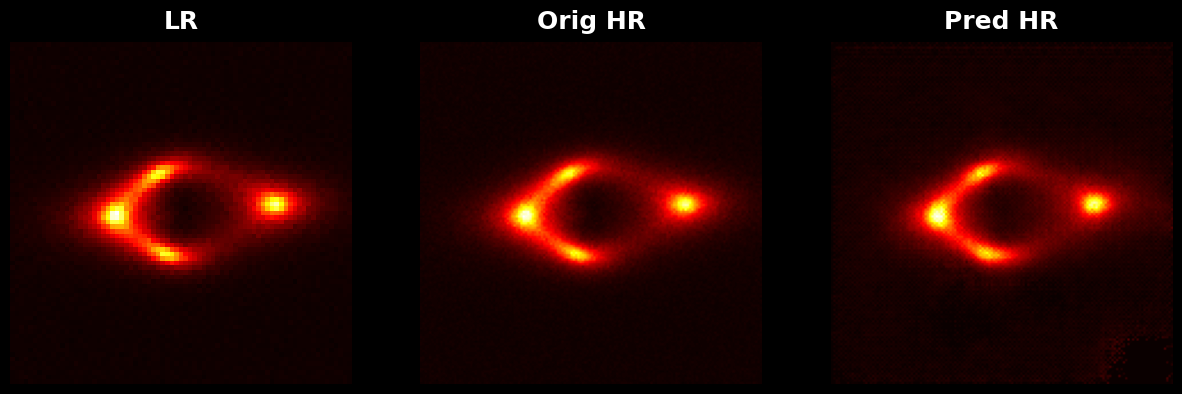

In [87]:
lr, hr = next(iter(test_loader))
pred = G(lr.to(device))
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,6))
ax1.imshow(lr[0][0],cmap='hot')
ax1.set_title('LR',fontsize=18,fontweight='bold',pad=10)
ax1.axis('off')
ax2.imshow(hr[0][0].detach(),cmap='hot')
ax2.set_title('Orig HR',fontsize=18,fontweight='bold',pad=10)
ax2.axis('off')
ax3.imshow(pred.detach()[0][0],cmap='hot')
ax3.set_title('Pred HR',fontsize=18,fontweight='bold',pad=10)
ax3.axis('off')
plt.show()

#### SRGAN Evaluation metrics summary

In [88]:
pd.DataFrame({'Metrics':['MSE', 'SSIM', 'PSNR'],
              'Score':[MSE, SSIM, PSNR]})

,Metrics,Score
0,MSE,0.000497
1,SSIM,0.826154
2,PSNR,38.239982


## Task 3B

### Data Visualization

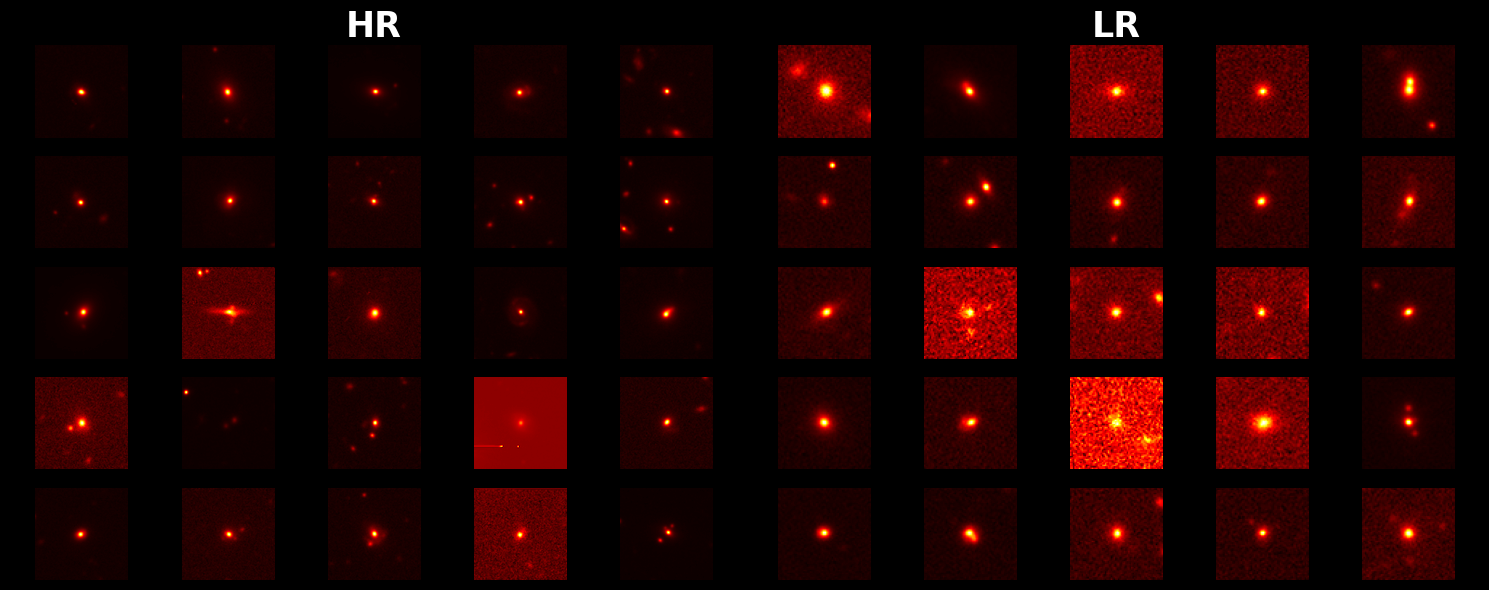

In [103]:
# Loading data
path=Path('datasets/Test 3B')
dirs = [i for i in path.iterdir() if i.name in ['LR', 'HR']]
fig = plt.figure(figsize = (15,6))
iax = gridspec.GridSpec(1, 2, figure=fig)

grid = 5 # no. of images in each row and column of the grid (can be changed to anything)

# Plotting grid
for ax, cls in zip(iax, dirs):
    out_ax = fig.add_subplot(ax)
    out_ax.set_title(f'{cls.name}', fontsize=25, fontweight='bold')
    out_ax.axis('off')
    jax = gridspec.GridSpecFromSubplotSpec(grid, grid, subplot_spec=ax)
    for i, img in zip(range(grid**2), cls.glob('*.npy')):
        in_ax = fig.add_subplot(jax[i//grid, i%grid])
        in_ax.imshow(np.load(img)[0], cmap='hot')
        in_ax.axis('off')
plt.tight_layout()

### Data Pipeline

In [110]:
class data (Dataset):
    
    def __init__(self, transform_lr: Compose, transform_hr: Compose, split: str) -> None:
        
        self.path: Path = Path.cwd() / 'datasets' / 'Test 3B' # Path object

        # Creating LR-HR path pair
        self.LR_HR_pair: List[tuple] = [(file1,file2) for file1,file2 in zip((self.path/'LR').iterdir(),(self.path/'HR').iterdir())]

        # train/test/val splitting based on choice
        self.train, self.val, self.test = random_split(self.LR_HR_pair,[0.85,0.05,0.1])
        self.loader: Subset = self.train if split == 'train' else (self.test if split == 'test' else self.val)

        # Image transforms
        self.transform_lr = transform_lr
        self.transform_hr = transform_hr

    def __len__(self) -> int:
        return len(self.loader)
        
    def __getitem__(self, i: int) -> Tuple[Tensor, Tensor]:
        return self.transform_lr(np.load(self.loader[i][0])), self.transform_hr(np.load(self.loader[i][1]))

### Data Loaders

In [172]:
train_loader = DataLoader(data(transforms_lr, transforms_hr, 'train'), batch_size=16, shuffle=True)
val_loader = DataLoader(data(transforms_lr, transforms_hr, 'val'), batch_size=16, shuffle=True)
test_loader = DataLoader(data(transforms_lr, transforms_hr, 'test'), batch_size=16, shuffle=True)

This task is performed by fine-tuning the two models (SRCNN,SRGAN) from Task 3A on the given dataset independently. This shows which model performs better in super resolution when limited data is available

### Fine tuning SRCNN pre-trained model

#### Fine tuning initialization

In [130]:
# Cloning model
model2 = SRCNN().to(device)
model2.load_state_dict(torch.load('chkpt_srcnn.pt')['model'])

l = nn.MSELoss()                                            # loss function
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0003)
epochs = 20
model2.train()                                              # setting model to training mode
met_train = list()                                          # storing training metrics
met_val = list()                                            # storing validation metrics

#### Fine Tuning

In [131]:
for epoch in range(epochs):
    m1,m2,m3 = 0,0,0
    for i, (lr, hr) in enumerate(tqdm(train_loader, desc = f'Epochs: {epoch+1}/{epochs}', ncols = 100)):
        
        optimizer.zero_grad()                   # initializing gradients to zero
        y_pred = model2(lr.to(device))           # model prediction
        loss = l(y_pred, hr.to(device))         # MSE loss calculation
        loss.backward()                         # Backpropagation (gradient calculation)
        
        with torch.no_grad():
            optimizer.step()                    # one step towards steepest gradient
            m1 += mse(y_pred.detach(),hr)       # mse accumulation
            m2 += ssim(y_pred.detach(),hr)      # ssim accumulation
            m3 += psnr(y_pred.detach(),hr)      # psnr accumulation
            
    with torch.no_grad():
        met_train.append({'mse':m1/(i+1), 'ssim':m2/(i+1), 'psnr':m3/(i+1)})
        print(f"MSE: {met_train[-1]['mse']} \t  SSIM: {met_train[-1]['ssim']} \t  PSNR: {met_train[-1]['psnr']}\n")

        # Validation
        m1,m2,m3 = 0,0,0
        for i, (lr, hr) in enumerate(tqdm(val_loader, desc = f'Validating: ')):
            pred = model2(lr.to(device))
            m1 += mse(pred.detach(), hr)
            m2 += ssim(pred.detach(), hr)
            m3 += psnr(pred.detach(), hr)
        met_val.append({'mse':m1/(i+1), 'ssim':m2/(i+1), 'psnr':m3/(i+1)})
        print(f"MSE: {met_val[-1]['mse']} \t  SSIM: {met_val[-1]['ssim']} \t  PSNR: {met_val[-1]['psnr']}\n")

Epochs: 1/20: 100%|███████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.94it/s]


MSE: 0.0029999667312949896 	  SSIM: 0.5991914793848991 	  PSNR: 42.4307307368611



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.45it/s]


MSE: 0.002044323366135359 	  SSIM: 0.6400107145309448 	  PSNR: 42.59557904060907



Epochs: 2/20: 100%|███████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


MSE: 0.0019222471164539456 	  SSIM: 0.6763730347156525 	  PSNR: 42.516781862223326



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13it/s]


MSE: 0.001691117649897933 	  SSIM: 0.6057453155517578 	  PSNR: 42.59557904060907



Epochs: 3/20: 100%|███████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.73it/s]


MSE: 0.0017097815871238708 	  SSIM: 0.6332426071166992 	  PSNR: 42.097444387156415



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.83it/s]


MSE: 0.0016230192268267274 	  SSIM: 0.5783289074897766 	  PSNR: 42.59557904060907



Epochs: 4/20: 100%|███████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


MSE: 0.0016498120967298746 	  SSIM: 0.6155159696936607 	  PSNR: 42.24746768452721



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.07it/s]


MSE: 0.0015672891167923808 	  SSIM: 0.5823829770088196 	  PSNR: 42.59557904060907



Epochs: 5/20: 100%|███████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


MSE: 0.0015995858702808619 	  SSIM: 0.6374100893735886 	  PSNR: 42.53606031647443



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 36.64it/s]


MSE: 0.00153890042565763 	  SSIM: 0.6119844913482666 	  PSNR: 42.59557904060907



Epochs: 6/20: 100%|███████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


MSE: 0.001564693870022893 	  SSIM: 0.6646454855799675 	  PSNR: 42.53150706823004



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.26it/s]


MSE: 0.001513191033154726 	  SSIM: 0.6291137337684631 	  PSNR: 42.59557904060907



Epochs: 7/20: 100%|███████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


MSE: 0.0015375976217910647 	  SSIM: 0.6733293309807777 	  PSNR: 42.49073466361903



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.94it/s]


MSE: 0.001478899852372706 	  SSIM: 0.6307964324951172 	  PSNR: 42.59557904060907



Epochs: 8/20: 100%|███████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.65it/s]


MSE: 0.0015125555219128728 	  SSIM: 0.6755722388625145 	  PSNR: 42.48333515800209



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.76it/s]


MSE: 0.0014528651954606175 	  SSIM: 0.6418477296829224 	  PSNR: 42.59557904060907



Epochs: 9/20: 100%|███████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


MSE: 0.0014914162456989288 	  SSIM: 0.6896098703145981 	  PSNR: 42.46874090548192



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.94it/s]


MSE: 0.0014316191663965583 	  SSIM: 0.6644628047943115 	  PSNR: 42.59557904060907



Epochs: 10/20: 100%|██████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


MSE: 0.0014805347891524434 	  SSIM: 0.7146501988172531 	  PSNR: 42.52669923201685



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.04it/s]


MSE: 0.0014156150864437222 	  SSIM: 0.6838154196739197 	  PSNR: 42.59557904060907



Epochs: 11/20: 100%|██████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.65it/s]


MSE: 0.0014634707476943731 	  SSIM: 0.7268335446715355 	  PSNR: 42.45698762327069



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.00it/s]


MSE: 0.001400805078446865 	  SSIM: 0.6884187459945679 	  PSNR: 42.59557904060907



Epochs: 12/20: 100%|██████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.62it/s]


MSE: 0.0014545791782438755 	  SSIM: 0.7355000823736191 	  PSNR: 42.51646904613056



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.41it/s]


MSE: 0.0013953326269984245 	  SSIM: 0.7091041803359985 	  PSNR: 42.59557904060907



Epochs: 13/20: 100%|██████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.59it/s]


MSE: 0.0014428956201300025 	  SSIM: 0.7501715198159218 	  PSNR: 42.514123573390115



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.60it/s]


MSE: 0.0013707682956010103 	  SSIM: 0.7054335474967957 	  PSNR: 42.59557904060907



Epochs: 14/20: 100%|██████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.64it/s]


MSE: 0.0014331499114632607 	  SSIM: 0.7371885627508163 	  PSNR: 42.44175892099256



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 36.23it/s]


MSE: 0.001366463373415172 	  SSIM: 0.7064865827560425 	  PSNR: 42.59557904060907



Epochs: 15/20: 100%|██████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


MSE: 0.0014274339191615582 	  SSIM: 0.7564316689968109 	  PSNR: 42.49614738176047



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.35it/s]


MSE: 0.0013603511033579707 	  SSIM: 0.7178174257278442 	  PSNR: 42.59557904060907



Epochs: 16/20: 100%|██████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


MSE: 0.001416652463376522 	  SSIM: 0.7563668563961983 	  PSNR: 42.510735450052124



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.79it/s]


MSE: 0.00133853021543473 	  SSIM: 0.7075385451316833 	  PSNR: 42.59557904060907



Epochs: 17/20: 100%|██████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


MSE: 0.001417255960404873 	  SSIM: 0.7294749394059181 	  PSNR: 42.53340548718626



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.36it/s]


MSE: 0.0013476136373355985 	  SSIM: 0.7157709002494812 	  PSNR: 42.59557904060907



Epochs: 18/20: 100%|██████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.50it/s]


MSE: 0.0014142736326903105 	  SSIM: 0.7656082361936569 	  PSNR: 42.49521603127567



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.92it/s]


MSE: 0.001350166741758585 	  SSIM: 0.7243325710296631 	  PSNR: 42.59557904060907



Epochs: 19/20: 100%|██████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


MSE: 0.0014094151556491852 	  SSIM: 0.7539898008108139 	  PSNR: 42.5094580999557



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.35it/s]


MSE: 0.001331840641796589 	  SSIM: 0.702621579170227 	  PSNR: 42.59557904060907



Epochs: 20/20: 100%|██████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.64it/s]


MSE: 0.0013926137471571565 	  SSIM: 0.7452693432569504 	  PSNR: 42.52689323037191



Validating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 36.85it/s]

MSE: 0.001338202622719109 	  SSIM: 0.7276034951210022 	  PSNR: 42.59557904060907



#### Evaluation

In [132]:
model2.eval() # setting model to evaluation mode

with torch.no_grad():
    m1,m2,m3 = 0,0,0
    for i, (lr, hr) in enumerate(tqdm(test_loader, desc = f'Evaluating: ')):
        pred = model2(lr.to(device))
        m1 += mse(pred.detach(), hr)
        m2 += ssim(pred.detach(), hr)
        m3 += psnr(pred.detach(), hr)
    print(f"\nMSE: {m1/(i+1)} \t  SSIM: {m2/(i+1)} \t  PSNR: {m3/(i+1)}\n")

# Saving metrics
MSE = (m1/(i+1)).item()
SSIM = (m2/(i+1)).item()
PSNR = (m3/(i+1)).item()

Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


MSE: 0.0016769219655543566 	  SSIM: 0.7176783084869385 	  PSNR: 42.21299911300936



#### Sample Predictions

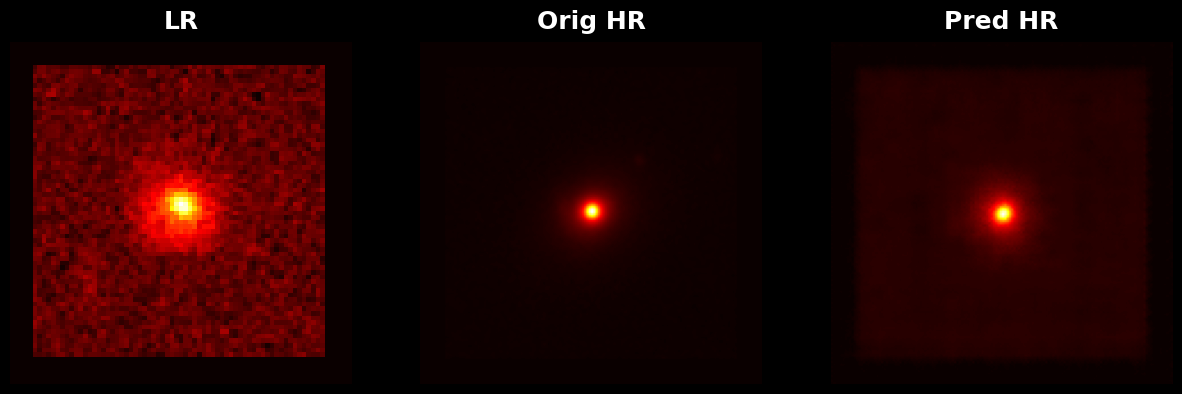

In [144]:
lr, hr = next(iter(test_loader))
pred = model2(lr.to(device))
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,6))
ax1.imshow(lr[0][0],cmap='hot')
ax1.set_title('LR',fontsize=18,fontweight='bold',pad=10)
ax1.axis('off')
ax2.imshow(hr[0][0].detach(),cmap='hot')
ax2.set_title('Orig HR',fontsize=18,fontweight='bold',pad=10)
ax2.axis('off')
ax3.imshow(pred.detach()[0][0],cmap='hot')
ax3.set_title('Pred HR',fontsize=18,fontweight='bold',pad=10)
ax3.axis('off')
plt.show()

#### SRCNN fine tuning evaluation metrics summary

In [145]:
pd.DataFrame({'Metrics':['MSE', 'SSIM', 'PSNR'],
              'Score':[MSE, SSIM, PSNR]})

,Metrics,Score
0,MSE,0.001677
1,SSIM,0.717678
2,PSNR,42.212999


### Fine tuning SRGAN pre-trained model (using FreezeD technique)

In the FreezeD techninque, the pre-trained SRGAN model is trainined in adversarial fashion on the new fine-tuning dataset but without updating the weights of the discriminator. This method has been proved to perform better on tasks related to fine-tuning GANs. ([Paper Link](https://arxiv.org/abs/2002.10964))

#### Initialization

In [175]:
# Cloning SRGAN models
D2 = Discriminator().to(device)
G2 = Generator().to(device)
G2.load_state_dict(torch.load('gen_chkpt.pt'))
D2.load_state_dict(torch.load('dis_chkpt.pt'))

# Freezing the discriminator
for p in D2.parameters():
    p.requires_grad=False
l = nn.BCELoss()
gen_opt = torch.optim.Adam(G2.parameters(), lr=0.0003)
G2.train()
epochs = 50

In [78]:
for epoch in range(epochs):
    dl,gl=0,0
    for i, (lr, hr) in enumerate(tqdm(train_loader, desc=f'Epochs: {epoch+1}/{epochs}', ncols=100)):

        # Generator fine tuning with freezed discriminator
        gen_opt.zero_grad()
        g_out = G2(lr.to(device))                                                                 # Generator output
        d_fake = D2(g_out)                                                                        # Fake probability
        g_loss = 1e-3 * l(d_fake, torch.ones_like(d_fake).to(device)) + mse(g_out, hr.to(device)) # Hybrid loss
        g_loss.backward()                                                                         # Gradient calculation
        with torch.no_grad():
            gen_opt.step()
            gl+=g_loss.item()
    print(f'GLoss: {gl/(i+1)}')

    # Validation
    with torch.no_grad():
        m1,m2,m3 = 0,0,0
        for i, (lr, hr) in enumerate(tqdm(val_loader, desc=f'Validating: ')):
            pred = G2(lr.to(device))
            m1 += mse(pred.detach(), hr)
            m2 += ssim(pred.detach(), hr)
            m3 += psnr(pred.detach(), hr)
        print(f"\nMSE: {m1/(i+1)} \t  SSIM: {m2/(i+1)} \t  PSNR: {m3/(i+1)}\n")

Epochs: 1/50: 100%|█████████████████████████████████████████████████| 16/16 [00:51<00:00,  3.23s/it]


GLoss: 0.0009817195932555478


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  6.56it/s]



MSE: 0.0007952036103233695 	  SSIM: 0.6528444886207581 	  PSNR: 41.99342405622673



Epochs: 2/50: 100%|█████████████████████████████████████████████████| 16/16 [00:50<00:00,  3.17s/it]


GLoss: 0.0008248485864896793


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  6.93it/s]



MSE: 0.0007388021913357079 	  SSIM: 0.6989446878433228 	  PSNR: 41.99342405622673



Epochs: 3/50: 100%|█████████████████████████████████████████████████| 16/16 [00:46<00:00,  2.90s/it]


GLoss: 0.0007482688397431048


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  7.06it/s]



MSE: 0.0006626957911066711 	  SSIM: 0.7356014251708984 	  PSNR: 41.99342405622673



Epochs: 4/50: 100%|█████████████████████████████████████████████████| 16/16 [00:49<00:00,  3.09s/it]


GLoss: 0.0006795320077799261


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  7.97it/s]



MSE: 0.0006391378701664507 	  SSIM: 0.7547866702079773 	  PSNR: 41.99342405622673



Epochs: 5/50: 100%|█████████████████████████████████████████████████| 16/16 [01:00<00:00,  3.75s/it]


GLoss: 0.0006508005735668121


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.95it/s]



MSE: 0.0006291422178037465 	  SSIM: 0.7552622556686401 	  PSNR: 41.99342405622673



Epochs: 6/50: 100%|█████████████████████████████████████████████████| 16/16 [01:00<00:00,  3.76s/it]


GLoss: 0.0006519764119730098


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  7.89it/s]



MSE: 0.0006583250360563397 	  SSIM: 0.7587057948112488 	  PSNR: 41.99342405622673



Epochs: 7/50: 100%|█████████████████████████████████████████████████| 16/16 [00:59<00:00,  3.70s/it]


GLoss: 0.0006458377338276478


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  3.41it/s]



MSE: 0.0006480750162154436 	  SSIM: 0.7393465638160706 	  PSNR: 41.99342405622673



Epochs: 8/50: 100%|█████████████████████████████████████████████████| 16/16 [00:58<00:00,  3.63s/it]


GLoss: 0.0006017234009050298


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  6.41it/s]



MSE: 0.0006030087824910879 	  SSIM: 0.7606174945831299 	  PSNR: 41.99342405622673



Epochs: 9/50: 100%|█████████████████████████████████████████████████| 16/16 [00:55<00:00,  3.50s/it]


GLoss: 0.0005691238820872968


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.15it/s]



MSE: 0.0005916247027926147 	  SSIM: 0.7697664499282837 	  PSNR: 41.99342405622673



Epochs: 10/50: 100%|████████████████████████████████████████████████| 16/16 [00:52<00:00,  3.26s/it]


GLoss: 0.0005028617124480661


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  7.71it/s]



MSE: 0.0005728928954340518 	  SSIM: 0.7655729055404663 	  PSNR: 41.99342405622673



Epochs: 11/50: 100%|████████████████████████████████████████████████| 16/16 [00:52<00:00,  3.30s/it]


GLoss: 0.00048303021685569547


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  6.71it/s]



MSE: 0.0005127904005348682 	  SSIM: 0.7808709740638733 	  PSNR: 41.71976042380493



Epochs: 12/50: 100%|████████████████████████████████████████████████| 16/16 [00:50<00:00,  3.15s/it]


GLoss: 0.00046781081618973985


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  7.82it/s]



MSE: 0.0004921998479403555 	  SSIM: 0.7801880240440369 	  PSNR: 41.99342405622673



Epochs: 13/50: 100%|████████████████████████████████████████████████| 16/16 [00:49<00:00,  3.11s/it]


GLoss: 0.0004794703818333801


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.59it/s]



MSE: 0.0005588774802163243 	  SSIM: 0.761102020740509 	  PSNR: 41.99342405622673



Epochs: 14/50: 100%|████████████████████████████████████████████████| 16/16 [00:49<00:00,  3.10s/it]


GLoss: 0.0004928767230012454


Validating: 100%|████████████████████████| 1/1 [00:00<00:00, 10.02it/s]



MSE: 0.0004947099951095879 	  SSIM: 0.7694584727287292 	  PSNR: 41.99342405622673



Epochs: 15/50: 100%|████████████████████████████████████████████████| 16/16 [00:49<00:00,  3.07s/it]


GLoss: 0.0004709365857706871


Validating: 100%|████████████████████████| 1/1 [00:00<00:00, 10.32it/s]



MSE: 0.000490991398692131 	  SSIM: 0.7863481044769287 	  PSNR: 41.71976042380493



Epochs: 16/50: 100%|████████████████████████████████████████████████| 16/16 [00:49<00:00,  3.10s/it]


GLoss: 0.00043846105836564675


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.90it/s]



MSE: 0.00043697445653378963 	  SSIM: 0.7747154235839844 	  PSNR: 41.71976042380493



Epochs: 17/50: 100%|████████████████████████████████████████████████| 16/16 [00:48<00:00,  3.04s/it]


GLoss: 0.0003935918321076315


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  9.34it/s]



MSE: 0.0004591320757754147 	  SSIM: 0.7895606160163879 	  PSNR: 41.71976042380493



Epochs: 18/50: 100%|████████████████████████████████████████████████| 16/16 [00:51<00:00,  3.19s/it]


GLoss: 0.0003735491609404562


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  6.85it/s]



MSE: 0.000395437324186787 	  SSIM: 0.7928611636161804 	  PSNR: 41.99342405622673



Epochs: 19/50: 100%|████████████████████████████████████████████████| 16/16 [00:49<00:00,  3.07s/it]


GLoss: 0.00038783001218689606


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.87it/s]



MSE: 0.00040244258707389235 	  SSIM: 0.8065832853317261 	  PSNR: 41.71976042380493



Epochs: 20/50: 100%|████████████████████████████████████████████████| 16/16 [00:45<00:00,  2.87s/it]


GLoss: 0.0003629943857959006


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.36it/s]



MSE: 0.0003926162899006158 	  SSIM: 0.8062133193016052 	  PSNR: 41.99342405622673



Epochs: 21/50: 100%|████████████████████████████████████████████████| 16/16 [00:45<00:00,  2.87s/it]


GLoss: 0.00034692940971581265


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  9.64it/s]



MSE: 0.00037349859485402703 	  SSIM: 0.8015424013137817 	  PSNR: 41.71976042380493



Epochs: 22/50: 100%|████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.81s/it]


GLoss: 0.0004035517376905773


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.56it/s]



MSE: 0.0003701065725181252 	  SSIM: 0.8186671137809753 	  PSNR: 41.99342405622673



Epochs: 23/50: 100%|████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.79s/it]


GLoss: 0.00036314707176643424


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.73it/s]



MSE: 0.00037798829725943506 	  SSIM: 0.7959643602371216 	  PSNR: 41.99342405622673



Epochs: 24/50: 100%|████████████████████████████████████████████████| 16/16 [00:45<00:00,  2.87s/it]


GLoss: 0.00034407533894409426


Validating: 100%|████████████████████████| 1/1 [00:00<00:00, 11.80it/s]



MSE: 0.00037005182821303606 	  SSIM: 0.7936915159225464 	  PSNR: 41.99342405622673



Epochs: 25/50: 100%|████████████████████████████████████████████████| 16/16 [00:45<00:00,  2.87s/it]


GLoss: 0.00032129210376297124


Validating: 100%|████████████████████████| 1/1 [00:00<00:00, 10.44it/s]



MSE: 0.00033167077344842255 	  SSIM: 0.8150033950805664 	  PSNR: 41.99342405622673



Epochs: 26/50: 100%|████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.81s/it]


GLoss: 0.00034997615512111224


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.35it/s]



MSE: 0.00035271115484647453 	  SSIM: 0.8060389161109924 	  PSNR: 41.559677461027036



Epochs: 27/50: 100%|████████████████████████████████████████████████| 16/16 [00:47<00:00,  2.95s/it]


GLoss: 0.00030138013516989304


Validating: 100%|████████████████████████| 1/1 [00:00<00:00, 13.94it/s]



MSE: 0.00031827876227907836 	  SSIM: 0.8171865940093994 	  PSNR: 41.99342405622673



Epochs: 28/50: 100%|████████████████████████████████████████████████| 16/16 [01:00<00:00,  3.76s/it]


GLoss: 0.0003431503464526031


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  5.89it/s]



MSE: 0.000334276381181553 	  SSIM: 0.8017545938491821 	  PSNR: 41.71976042380493



Epochs: 29/50: 100%|████████████████████████████████████████████████| 16/16 [00:56<00:00,  3.54s/it]


GLoss: 0.0003182449208907201


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.40it/s]



MSE: 0.0003397760447114706 	  SSIM: 0.8223375082015991 	  PSNR: 41.99342405622673



Epochs: 30/50: 100%|████████████████████████████████████████████████| 16/16 [00:57<00:00,  3.58s/it]


GLoss: 0.0002989769245687057


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  6.57it/s]



MSE: 0.0002833239850588143 	  SSIM: 0.8343079686164856 	  PSNR: 41.357996779557624



Epochs: 31/50: 100%|████████████████████████████████████████████████| 16/16 [00:55<00:00,  3.50s/it]


GLoss: 0.0002911543278969475


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  6.36it/s]



MSE: 0.0003325997095089406 	  SSIM: 0.8235491514205933 	  PSNR: 41.99342405622673



Epochs: 32/50: 100%|████████████████████████████████████████████████| 16/16 [00:55<00:00,  3.44s/it]


GLoss: 0.00028974281394766876


Validating: 100%|████████████████████████| 1/1 [00:00<00:00, 10.42it/s]



MSE: 0.00029658692074008286 	  SSIM: 0.8305088877677917 	  PSNR: 41.286013828605235



Epochs: 33/50: 100%|████████████████████████████████████████████████| 16/16 [00:57<00:00,  3.60s/it]


GLoss: 0.0002728896597545827


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  5.58it/s]



MSE: 0.00030126809724606574 	  SSIM: 0.821334183216095 	  PSNR: 41.71976042380493



Epochs: 34/50: 100%|████████████████████████████████████████████████| 16/16 [00:55<00:00,  3.45s/it]


GLoss: 0.0003141875213259482


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  6.78it/s]



MSE: 0.00029996203375048935 	  SSIM: 0.8264482617378235 	  PSNR: 41.559677461027036



Epochs: 35/50: 100%|████████████████████████████████████████████████| 16/16 [00:55<00:00,  3.46s/it]


GLoss: 0.0002903506874645245


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  7.59it/s]



MSE: 0.0003328131861053407 	  SSIM: 0.8057869672775269 	  PSNR: 41.286013828605235



Epochs: 36/50: 100%|████████████████████████████████████████████████| 16/16 [00:50<00:00,  3.16s/it]


GLoss: 0.00035732848118641414


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.24it/s]



MSE: 0.00035100762033835053 	  SSIM: 0.812859833240509 	  PSNR: 41.71976042380493



Epochs: 37/50: 100%|████████████████████████████████████████████████| 16/16 [01:06<00:00,  4.18s/it]


GLoss: 0.0002793985322568915


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  7.24it/s]



MSE: 0.0002866976719815284 	  SSIM: 0.825657308101654 	  PSNR: 41.99342405622673



Epochs: 38/50: 100%|████████████████████████████████████████████████| 16/16 [00:48<00:00,  3.04s/it]


GLoss: 0.0002611048603284871


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  4.98it/s]



MSE: 0.0003247582644689828 	  SSIM: 0.8101603984832764 	  PSNR: 41.99342405622673



Epochs: 39/50: 100%|████████████████████████████████████████████████| 16/16 [01:01<00:00,  3.84s/it]


GLoss: 0.00029427692879835377


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  7.56it/s]



MSE: 0.00029439767240546644 	  SSIM: 0.8259198665618896 	  PSNR: 41.99342405622673



Epochs: 40/50: 100%|████████████████████████████████████████████████| 16/16 [00:49<00:00,  3.12s/it]


GLoss: 0.0002700707300391514


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.51it/s]



MSE: 0.00025604545953683555 	  SSIM: 0.8374555706977844 	  PSNR: 41.71976042380493



Epochs: 41/50: 100%|████████████████████████████████████████████████| 16/16 [00:47<00:00,  2.96s/it]


GLoss: 0.00026272408467775676


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.20it/s]



MSE: 0.0003109749231953174 	  SSIM: 0.79581218957901 	  PSNR: 41.08433314713582



Epochs: 42/50: 100%|████████████████████████████████████████████████| 16/16 [00:49<00:00,  3.07s/it]


GLoss: 0.00042474708607187495


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.19it/s]



MSE: 0.0003223004168830812 	  SSIM: 0.8156612515449524 	  PSNR: 41.99342405622673



Epochs: 43/50: 100%|████████████████████████████████████████████████| 16/16 [00:45<00:00,  2.83s/it]


GLoss: 0.00032891223054321017


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.63it/s]



MSE: 0.00029799624462611973 	  SSIM: 0.8181828260421753 	  PSNR: 40.92425018435793



Epochs: 44/50: 100%|████████████████████████████████████████████████| 16/16 [00:47<00:00,  2.95s/it]


GLoss: 0.0002721412283790414


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  9.02it/s]



MSE: 0.00029239451396279037 	  SSIM: 0.8274131417274475 	  PSNR: 41.99342405622673



Epochs: 45/50: 100%|████████████████████████████████████████████████| 16/16 [00:50<00:00,  3.14s/it]


GLoss: 0.0002470451236149529


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  9.43it/s]



MSE: 0.0002491523919161409 	  SSIM: 0.8367474675178528 	  PSNR: 41.99342405622673



Epochs: 46/50: 100%|████████████████████████████████████████████████| 16/16 [00:45<00:00,  2.84s/it]


GLoss: 0.0003052634037885582


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.21it/s]



MSE: 0.00031514710281044245 	  SSIM: 0.8133400678634644 	  PSNR: 41.44609679138313



Epochs: 47/50: 100%|████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.78s/it]


GLoss: 0.0002583065370345139


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  8.88it/s]



MSE: 0.0002485194709151983 	  SSIM: 0.8467146158218384 	  PSNR: 41.99342405622673



Epochs: 48/50: 100%|████████████████████████████████████████████████| 16/16 [00:47<00:00,  2.97s/it]


GLoss: 0.0003079492180404486


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  9.51it/s]



MSE: 0.0003634737804532051 	  SSIM: 0.7565180659294128 	  PSNR: 41.012350196183434



Epochs: 49/50: 100%|████████████████████████████████████████████████| 16/16 [00:48<00:00,  3.03s/it]


GLoss: 0.0004145797011005925


Validating: 100%|████████████████████████| 1/1 [00:00<00:00,  7.96it/s]



MSE: 0.00030869198963046074 	  SSIM: 0.8268571496009827 	  PSNR: 41.99342405622673



Epochs: 50/50: 100%|████████████████████████████████████████████████| 16/16 [00:51<00:00,  3.20s/it]


GLoss: 0.00029371884284046246


Validating: 100%|████████████████████████| 1/1 [00:00<00:00, 11.71it/s]


MSE: 0.0002670789253897965 	  SSIM: 0.8339233994483948 	  PSNR: 41.99342405622673



#### Saving model parameters

In [181]:
torch.save(G2.state_dict(), 'chkpt_3b.pt')

#### Loading saved model parameters

In [182]:
G2.load_state_dict(torch.load('chkpt_3b.pt'))

<All keys matched successfully>

#### Evaluation

In [218]:
G2.eval() # setting model to evaluation mode

m1,m2,m3 = 0,0,0
for i, (lr, hr) in enumerate(tqdm(test_loader, desc=f'Evaluating: ')):
    pred = G2(lr.to(device))
    m1 += mse(pred.detach(), hr)
    m2 += ssim(pred.detach(), hr)
    m3 += psnr(pred.detach(), hr)
print(f"\nMSE: {m1/(i+1)} \t  SSIM: {m2/(i+1)} \t  PSNR: {m3/(i+1)}\n")

# Saving metrics
MSE = (m1/(i+1)).item()
SSIM = (m2/(i+1)).item()
PSNR = (m3/(i+1)).item()

Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18.48it/s]


MSE: 0.00020354363368824124 	  SSIM: 0.8389151990413666 	  PSNR: 41.87815314675116



#### Sample Predictions

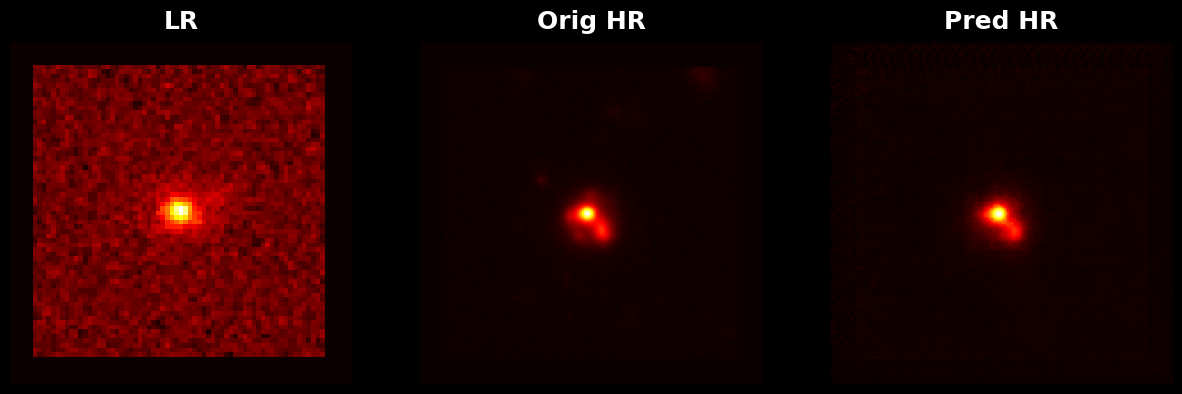

In [221]:
lr, hr = next(iter(test_loader))
pred = G2(lr.to(device))
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,6))
ax1.imshow(lr[0][0],cmap='hot')
ax1.set_title('LR',fontsize=18,fontweight='bold',pad=10)
ax1.axis('off')
ax2.imshow(hr[0][0].detach(),cmap='hot')
ax2.set_title('Orig HR',fontsize=18,fontweight='bold',pad=10)
ax2.axis('off')
ax3.imshow(pred.detach()[0][0],cmap='hot')
ax3.set_title('Pred HR',fontsize=18,fontweight='bold',pad=10)
ax3.axis('off')
plt.show()

#### SRGAN fine tuning evaluation metrics summary

In [220]:
pd.DataFrame({'Metrics':['MSE', 'SSIM', 'PSNR'],
              'Score':[MSE, SSIM, PSNR]})

,Metrics,Score
0,MSE,0.000204
1,SSIM,0.838915
2,PSNR,41.878153
